## IUM - projekt
#### Autorzy:
Joanna Sokołowska, Rafał Uzarowicz
#### Zadanie:
3. "Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Gdybyśmy
wiedzieli, ile taka dostawa dla danego zamówienia potrwa – moglibyśmy przekazywać tą
informację klientom."

In [1]:
# Ustawienie środowiska

# Wstępne dane
data_v1_dir ="/content/drive/MyDrive/Data/IUM/"

deliveries_v1_path = data_v1_dir + "deliveries.jsonl"
sessions_v1_path = data_v1_dir + "sessions.jsonl"
users_v1_path = data_v1_dir + "users.jsonl"
products_v1_path = data_v1_dir + "products.jsonl"

# Pierwsza aktualizacja
data_v2_dir ="/content/drive/MyDrive/Data/IUM/V2/"

deliveries_v2_path = data_v2_dir + "deliveries.jsonl"
sessions_v2_path = data_v2_dir + "sessions.jsonl"
users_v2_path = data_v2_dir + "users.jsonl"
products_v2_path = data_v2_dir + "products.jsonl"

# Biblioteki
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Zadanie

### Tło biznesowe

**Zadanie biznesowe**:
przewidywanie przybliżonego czasu dostawy produktu.

**Biznesowe kryterium sukcesu:**
przewidywany przez system czas dostawy nie powinien zbytnio odstawać od rzeczywistego czasu dostawy.
Zastosowanie systemu powinno sprawiać, że użytkownicy lepiej oceniają swoje doświadczenia ze sklepem.


### Model

**Zadanie modelowania:**
przewidywanie czasu dostawy przy użyciu regresji.

**Analityczne kryterium sukcesu:**
miara Median Absolute Error mniejsza niż 12h (720 min).
Dokładna wartość została oszacowana poprzez zbudowanie bazowego modelu regresji liniowej, którego miara MAE wynosi ok. 804 minuty (13,4h) na zbiorze testowym.

**Zmienna celu: **
przybliżona liczba minut potrzebnych na dostawę produktu.


## Wstępne obserwacje dotyczące danych

In [2]:
deliveries_v1 = pd.read_json(deliveries_v1_path, lines=True)
sessions_v1 = pd.read_json(sessions_v1_path, lines=True)
users_v1 = pd.read_json(users_v1_path, lines=True)
products_v1 = pd.read_json(products_v1_path, lines=True)

data_v1 = {"products": products_v1, "sessions": sessions_v1, "users": users_v1, "deliveries":deliveries_v1}

### Krótki opis danych
Dane, które dostaliśmy, dotyczą firmy internetowej sprzedającej elektronikę i gry komputerowe. Dostaliśmy bazę użytkowników,
 katalog produktów, historię sesji oraz dane dotyczące wysyłki zakupionych produktów. Ze względu na specyfikę problemu
 wydaje się, że jedynymi istotnymi informacjami będą te powiązane z samym transportem.

### Przegląd dostępnych kolumn

In [3]:
for key, value in data_v1.items():
    print(key, " : ", value.columns.tolist())

products  :  ['product_id', 'product_name', 'category_path', 'price']
sessions  :  ['session_id', 'timestamp', 'user_id', 'product_id', 'event_type', 'offered_discount', 'purchase_id']
users  :  ['user_id', 'name', 'city', 'street']
deliveries  :  ['purchase_id', 'purchase_timestamp', 'delivery_timestamp', 'delivery_company']


In [4]:
for key, value in data_v1.items():
    for column in value.columns.tolist():
        print(column, " : ", data_v1[key][column].dtypes)

product_id  :  int64
product_name  :  object
category_path  :  object
price  :  float64
session_id  :  int64
timestamp  :  datetime64[ns]
user_id  :  float64
product_id  :  float64
event_type  :  object
offered_discount  :  int64
purchase_id  :  float64
user_id  :  int64
name  :  object
city  :  object
street  :  object
purchase_id  :  int64
purchase_timestamp  :  object
delivery_timestamp  :  object
delivery_company  :  float64


#### Dane, które wydają się mieć największy wpływ na nasze zadanie:
- adres użytkownika (może być konieczne dodanie do niego kolumny z kodem pocztowym - powinno dać to lepsze pojęcie o
położeniu punktów dostaw w tym samym rejonie, dalszym przetworzeniem może być też odległość absolutna pomiędzy magazynem/miejscem wysyłki a adresem dostawy),
- dane dt. czasu złożenia zamówienia (prawdopodobnie trzeba będzie je przekształcić w format bardziej nadający się do obróbki),
- dane dt. czasu dostawy (atrybut, którego wartość będziemy próbowali przewidzieć  pośrednio tj. będziemy obliczać czas między złożeniem zamówienia a dostawą),
- dane dt. firmy kurierskiej (firma prawdopodobnie będzie mocno wpływać na czas dostawy).

#### Omówienie pozostałych danych:
- session_id - raczej nieistotne, sesja nie powinna mieć wpływu na czas transportu,
- timestamp z tabeli sessions - też raczej nieistotny, podobne informacje niesie timestamp zakupu produktu z tabeli deliveries,
gdyż nie obchodzi nas jakie produkty przeglądał użytkownik, a tylko akcje kupna,
- user_id - samo w sobie raczej nie niesie wartości, bo sklep internetowy raczej nie przyspiesza dostaw ze względu na osobę zamawiającego; może okazać się przydatny do łączenia z innymi tabelami (np. deliveries),
- product_id - przydatne tylko do łączenia tabel,
- event_type - raczej nieistotne, to co wykonywał użytkownik w sesji, nie ma wpływu na czas dostawy,
- offered_discount - nie powinno mieć to wpływu na czas dostawy.
- purchase_id - istotne do łączenia tabel,
- name - nie będzie to miało wpływu na czas dostawy,
- product_name - raczej nie powinno wpłynąć na czas dostawy,
- category_path - może być o tyle ważne, że pewne produkty mogłyby być gabarytami, wtedy ich czas dostawy mógłby się znacznie różnic przez konieczność specjalnego ich traktowania,
- price - cena sama w sobie raczej nie niesie informacji o czasie dostawy.

#### Dane, które przydałoby się dostać:
- dane dt. momentu i miejsca wysyłki produktów (czy zawsze wysyłane są z tego samego miejsca, czy istnieją jakieś opóźnienia),
- dane dt. punktów pośrednich na drodze przesyłki (o ile istnieją) np. punktów spedycyjnych, magazynów,
to potencjalnie mogłoby pozwolić na ulepszanie predykcji w trakcie podróży przesyłki i im bliżej celu, tym
dokładniejsze dane można by było zaprezentować użytkownikowi.

### Ogólne komentarze do tabel

Tabela deliveries - zawarte w niej daty i godziny są prawdopodobnie bardzo ważne w budowie modelu, ale będą
wymagały przetworzenia np. wydzielenia miesiąca, dnia, godziny, a może też dnia tygodnia.

Tabela sessions - raczej nieważna, choć spodziewamy się, że może nieść nieco istotnych danych nt. obciążenia systemu
w poszczególnych okresach, co prawdopodobnie wpływa na czas dostaw.

Tabela products - przy wstępnej analizie nie wydaje się istotna, ale może da się na jej podstawie utworzyć nowe atrybuty
bardziej przydatne dla problemu. Być może warto np. dodać do kolumny deliveries kolumnę zliczającą, ile przedmiotów
jest w jednym zamówieniu - wielkość zamówienia może wpływać na możliwości firm kurierskich co do czasu dostawy.

Tabela users - raczej ważna, bo mówi nam o adresie dostawy, a odległość od punktu wysyłki może znacząco wpływać na czas dostawy.

## Analiza pierwszej wersji danych

### Sprawdzenie ilości danych

In [5]:
for key, value in data_v1.items():
    print(key, " : ", value.shape)

products  :  (319, 4)
sessions  :  (37690, 7)
users  :  (200, 4)
deliveries  :  (6993, 4)


Ilościowo danych wydaje się dostatecznie dużo, w najbardziej interesującej nas tabeli (deliveries) jest niemal 7 tysięcy
wierszy, co powinno być dość zarówno do wytrenowania, walidacji, jak i testowania modelu.

### Sprawdzenie jakości danych

#### Sprawdzenie braków w danych

In [6]:
for key, value in data_v1.items():
  print(key, ":\n", value.isnull().sum(), "\n")

products :
 product_id       0
product_name     0
category_path    0
price            0
dtype: int64 

sessions :
 session_id              0
timestamp               0
user_id              1915
product_id           1913
event_type              0
offered_discount        0
purchase_id         30697
dtype: int64 

users :
 user_id    0
name       0
city       0
street     0
dtype: int64 

deliveries :
 purchase_id             0
purchase_timestamp      0
delivery_timestamp    333
delivery_company      329
dtype: int64 



Brakujące dane w tabeli deliveries są raczej martwiące, dobrze by było jakby dało się je uzupełnić, jednak jeśli nie
będzie to możliwe, to pozostałe dane powinny być wystarczające do wytrenowania modelu
(maksymalnie 662 wiersze są wybrakowane, to poniżej 10% danych).

Cieszy brak pustych wartości w tabelach dotyczących użytkowników, dzięki czemu nie powinno być problemu z nieznanymi adresami dostaw.

Braki w tabeli sessions nie zaskakują - wynikają prawdopodobnie ze sposobu, w jaki są gromadzone dane,
np. puste wartości w kolumnie purchase_id wynikają najpewniej z tego, że dany wiersz odpowiada wartości
event_type innej niż BUY_PRODUCT.

#### Sprawdzenie błędów w danych

##### Dane czasowe

In [7]:
deliveries_v1.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-02-21T12:09:40,2021-02-22T15:06:21.051360,620.0
1,20002,2021-02-17T15:08:51,2021-02-21T12:16:54.977640,360.0
2,20003,2021-01-22T14:41:01,2021-01-22T15:19:19.040428,516.0
3,20004,2021-01-15T12:41:14,2021-01-13T22:45:05.607434,516.0
4,20005,2021-01-14T02:50:19,2021-01-14T11:35:28.612753,516.0


In [8]:
deliveries_v1["purchase_timestamp"] = pd.to_datetime ( deliveries_v1["purchase_timestamp"], format='%Y-%m-%dT%H:%M', errors="coerce")
deliveries_v1['delivery_timestamp'] = pd.to_datetime ( deliveries_v1["delivery_timestamp"], format='%Y-%m-%dT%H:%M:%S', errors="coerce")
deliveries_v1["time_difference"] = deliveries_v1["delivery_timestamp"] - deliveries_v1["purchase_timestamp"]
deliveries_v1.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference
0,20001,2021-02-21 12:09:40,2021-02-22 15:06:21.051360,620.0,1 days 02:56:41.051360
1,20002,2021-02-17 15:08:51,2021-02-21 12:16:54.977640,360.0,3 days 21:08:03.977640
2,20003,2021-01-22 14:41:01,2021-01-22 15:19:19.040428,516.0,0 days 00:38:18.040428
3,20004,2021-01-15 12:41:14,2021-01-13 22:45:05.607434,516.0,-2 days +10:03:51.607434
4,20005,2021-01-14 02:50:19,2021-01-14 11:35:28.612753,516.0,0 days 08:45:09.612753


In [9]:
len(deliveries_v1[deliveries_v1["time_difference"] > pd.Timedelta(hours=0)])

4596

In [10]:
len(deliveries_v1[deliveries_v1["time_difference"] < pd.Timedelta(hours=0)])

2064

Ujemne wartości w nowoutworzonej kolumnie wskazują na to, że dane są zanieczyszczone-produkt nie mógł być dostarczony
przed zakupem. Takich zanieczyszczeń jest stosunkowo wiele - 2 tysiące wierszy, które przez to nie będą mogły zostać
wykorzystane w modelowaniu. To zbyt wiele danych, żebyśmy mogli je po prostu pominąć tak, jak w przypadku brakujących czasów dostawy.

In [11]:
preped = deliveries_v1[deliveries_v1["time_difference"] > pd.Timedelta(hours=0)].copy()
preped["time[s]"]=preped["time_difference"].apply(lambda time_delta: time_delta.total_seconds())
preped["time[h]"]=preped["time_difference"].apply(lambda x: x.total_seconds()/(60*60))
preped["delivery_weekday"]=preped['delivery_timestamp'].apply(lambda x: x.weekday())
preped.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference,time[s],time[h],delivery_weekday
0,20001,2021-02-21 12:09:40,2021-02-22 15:06:21.051360,620.0,1 days 02:56:41.051360,97001.051360,26.944736,0
1,20002,2021-02-17 15:08:51,2021-02-21 12:16:54.977640,360.0,3 days 21:08:03.977640,335283.977640,93.134438,6
2,20003,2021-01-22 14:41:01,2021-01-22 15:19:19.040428,516.0,0 days 00:38:18.040428,2298.040428,0.638345,4
4,20005,2021-01-14 02:50:19,2021-01-14 11:35:28.612753,516.0,0 days 08:45:09.612753,31509.612753,8.752670,3
5,20006,2021-02-16 08:27:14,2021-02-19 09:58:54.243499,620.0,3 days 01:31:40.243499,264700.243499,73.527845,4


<Figure size 1440x720 with 0 Axes>

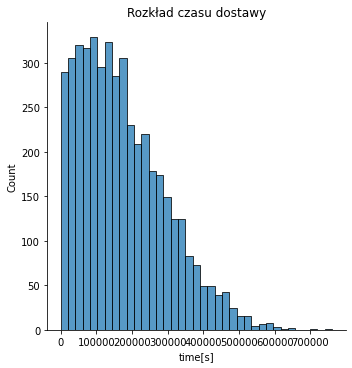

In [12]:
plt.figure(figsize=(20,10))
sns.displot(preped["time[s]"]).set(title="Rozkład czasu dostawy")

<Figure size 1440x720 with 0 Axes>

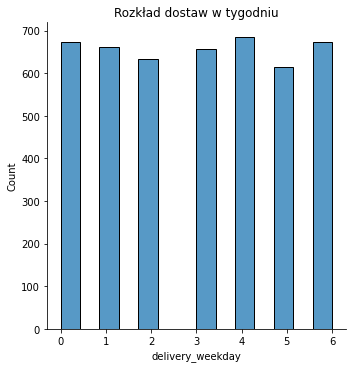

In [13]:
plt.figure(figsize=(20,10))
sns.displot(preped["delivery_weekday"]).set(title="Rozkład dostaw w tygodniu")

Paczki są dostarczane równomiernie w całym tygodniu. Jest to dziwne ze względu na dostarczanie paczek również w niedziele.
Trzeba będzie te kwestie omówić z klientem.

[Text(0.5, 1.0, 'Rozkład dostaw w tygodniu ( < 24h )')]

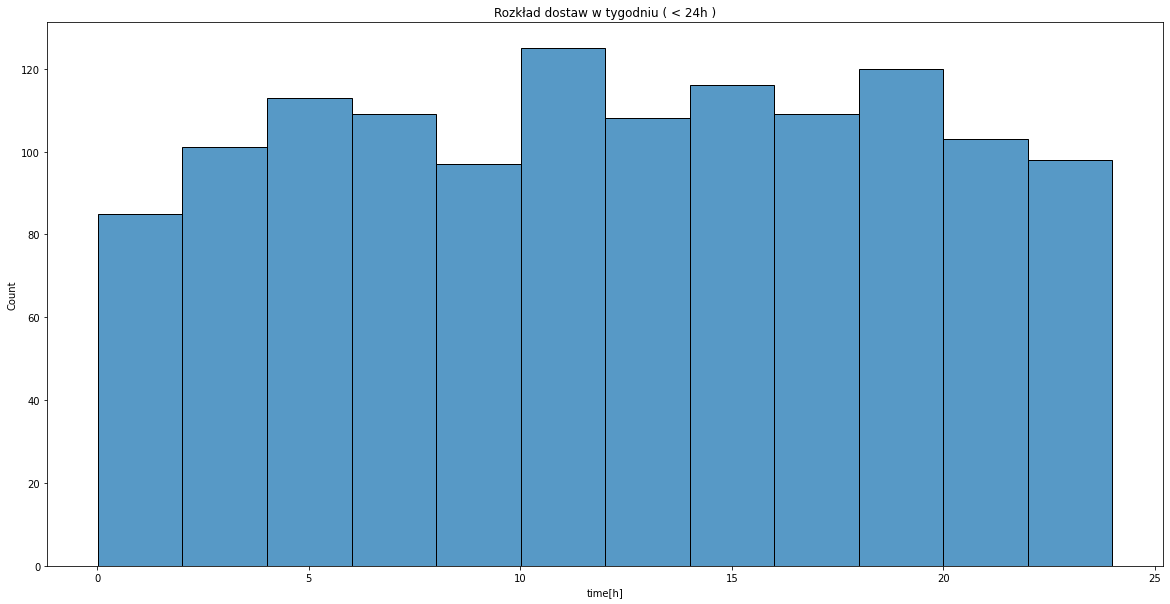

In [14]:
plt.figure(figsize=(20,10))
sns.histplot(preped[preped["time[h]"] < 24]["time[h]"]).set(title="Rozkład dostaw w tygodniu ( < 24h )")

Na pierwszy rzut oka martwiące są czasy dostawy poniżej godziny, ale także te krótkie - 2 lub 3 - godzinne.
Obecnym standardem w e-commerce jest dostawa przesyłki w ciągu 1-2 dni roboczych,
czyli czas dostawy od mniej więcej 10 do 30-kilku godzin. Być może te krótkie dane są poprawne, jeśli firma realizuje
dostawy ekspresowe (np. z usługą dostawy tego samego dnia) albo np. możliwość odbioru towaru z salonu, jeśli jest on w nim dostępny.

Podejrzanie krótkie czasy dostawy (poniżej 5 godzin) zdecydowanie wymagają wyjaśnienia z przedstawicielem firmy.

Warto jeszcze sprawdzić jak wygląda rozkład czasu dostawy w godzinach w podziale na poszczególne
firmy kurierskie-być może okaże się, że krótkie dostawy są realizowane tylko przez jedną firmę,
co wskazywałoby na prawidłowość hipotezy o możliwości wykupienia ekspresowej dostawy.

Ponadto warto też przyjrzeć się godzinom, w jakich realizowana jest dostawa-jest szansa,
że znajdziemy tam jakieś dostawy w nieprzyzwoicie nocnych godzinach.

Dane nt. czasu dostawy wymagają dokładniejszego przyjrzenia się ich rozkładowi.

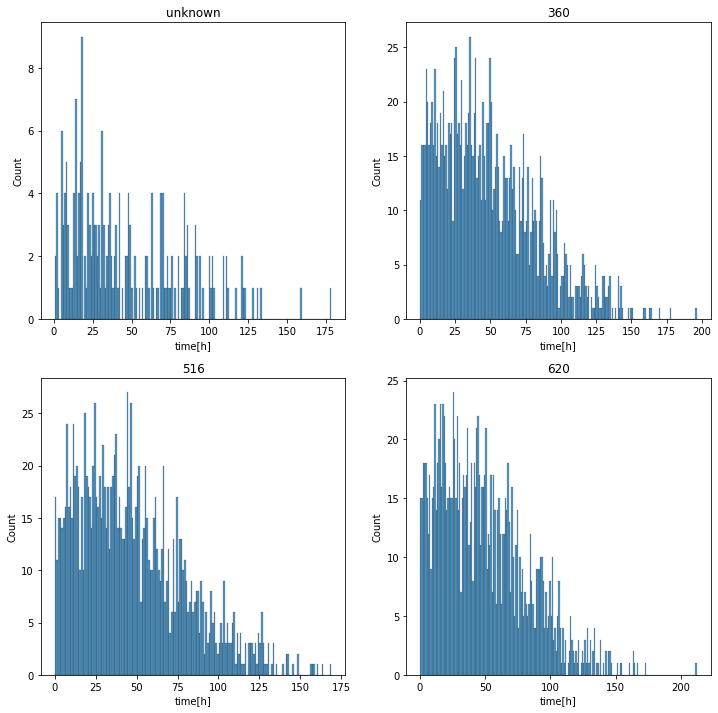

In [15]:
companies = preped["delivery_company"].unique()
dfs = {
    "unknown": preped[preped['delivery_company'].isna()]["time[h]"],
    "360": preped[preped['delivery_company']==360]["time[h]"],
    "516": preped[preped['delivery_company']==516]["time[h]"],
    "620": preped[preped['delivery_company']==620]["time[h]"]
}

fgs, axes = plt.subplots(2, 2, figsize=(12,12))
axs = [axes[i][j] for i in [0,1] for j in [0,1]]
i=0
for key, df in dfs.items():
  sns.histplot(data = df, binwidth=1, ax = axs[i])
  axs[i].title.set_text(key)
  i+=1
plt.show()

Nie wydaje się, żeby któraś z firm kurierskich dostarczała paczki znacznie szybciej od innych.

In [16]:
night_deliveries = pd.DataFrame({"id": preped["purchase_id"].to_list()}, index=pd.DatetimeIndex(preped["delivery_timestamp"])).between_time("22:00", "6:00")
print(len(night_deliveries))

1568


Z danych wynika, że paczki są dostarczane nawet w nocy. Jest to bardzo mało prawdopodobne i musi być omówione z klientem.

In [17]:
users_v1["city"].unique().tolist()


['Konin',
 'Kutno',
 'Radom',
 'Police',
 'Szczecin',
 'Warszawa',
 'Gdynia',
 'Mielec']

Paczki są dostarczane do miast w różnych rejonach Polski. Bardzo małe czasy dostawy w takiej sytuacji muszą wynikać z
błędu lub paczki są wysyłane z wielu miejsc.

### Sprawdzenie dostępnych kategorii produktów

In [18]:
categories = set()
for value in products_v1["category_path"]:
  categories.update(value.split(";"))
categories

{'Akcesoria telefoniczne',
 'Anteny RTV',
 'Audio',
 'Biurowe urządzenia wielofunkcyjne',
 'Drukarki i skanery',
 'Gry PlayStation3',
 'Gry Xbox 360',
 'Gry i konsole',
 'Gry komputerowe',
 'Gry na konsole',
 'Komputery',
 'Monitory',
 'Monitory LCD',
 'Odtwarzacze DVD',
 'Odtwarzacze mp3 i mp4',
 'Okulary 3D',
 'Przenośne audio i video',
 'Sprzęt RTV',
 'Słuchawki',
 'Tablety',
 'Tablety i akcesoria',
 'Telefony i akcesoria',
 'Telefony komórkowe',
 'Telefony stacjonarne',
 'Telewizory i akcesoria',
 'Video',
 'Zestawy głośnomówiące',
 'Zestawy słuchawkowe'}

Po przyjrzeniu się kategoriom można zauważyć, że gabaryty sprzedawanych przedmiotów nie będą się bardzo różnić -
choć transport monitorów LCD i słuchawek jest różny, to raczej nie dość różny, by wpłynąć na czas dostawy.
Mimo to można dodać kolumnę dzielącą przedmioty na większe np. Drukarki i skaner, Komputery, Monitory i Monitory LCD
jako urządzenia „duże", a telefony komórkowe, zestawy słuchawkowe i gry na konsole jako „małe".

### Wnioski

Dane, które wydają się mieć znaczenie, zawierają istotnie wiele błędów. Kontakt z klientem i wyjaśnienie podstawowych kwestii będzie kluczowe.

Po wstępnym obejrzeniu danych, z klientem należy ustalić następujące szczegóły:
- miejsce wysyłki paczek i jego adres
- trasa paczki
- dostępność produktów w sklepie

Wszystkie te kwestie mogą wpłynąć na zmienną celu.

Ważne będzie także zapytanie o uzupełnienie brakujących danych (w szczególnośći znaczniki czasowe dostawy)
oraz o błędne dane (krótkie czasy dostawy, ujemne czasy dostawy, dostawy w nocy i w niedziele).

## Analiza pierwszej aktualizacji zbioru danych



### Opis informacji od klienta

Dostaliśmy aktualizację danych po przedstawieniu problemów, jakie w nich znaleźliśmy.

Od klienta dowiedzieliśmy się, że istnieje jeden centralny magazyn (nie ma jego adresu), nie istnieją żadne miejsca
na ścieżce produktu do klienta, nie występuje czas oczekiwania na wysłanie, można kupić produkty tylko dostępne w magazynie
(brak czasu oczekiwania na dostawę do magazynu).

In [19]:
deliveries_v2 = pd.read_json(deliveries_v2_path, lines=True)
sessions_v2 = pd.read_json(sessions_v2_path, lines=True)
users_v2 = pd.read_json(users_v2_path, lines=True)
products_v2 = pd.read_json(products_v2_path, lines=True)

data_v2 = {"products": products_v2, "sessions": sessions_v2, "users": users_v2, "deliveries":deliveries_v2}

In [20]:
# Łączenie tabel w jedną tabelę

deliveries_v2["purchase_timestamp"] = pd.to_datetime ( deliveries_v2["purchase_timestamp"], format='%Y-%m-%dT%H:%M', errors="coerce")
deliveries_v2['delivery_timestamp'] = pd.to_datetime ( deliveries_v2["delivery_timestamp"], format='%Y-%m-%dT%H:%M:%S', errors="coerce")
deliveries_v2["time_difference"] = deliveries_v2["delivery_timestamp"] - deliveries_v2["purchase_timestamp"]

deliveries_v2["time[s]"]=deliveries_v2["time_difference"].apply(lambda time_delta: time_delta.total_seconds())
deliveries_v2["time[h]"]=deliveries_v2["time_difference"].apply(lambda x: x.total_seconds()/(60*60))

sessions_purchases = sessions_v2[sessions_v2["purchase_id"].notnull()].copy()
merged = pd.merge(sessions_purchases, deliveries_v2, on='purchase_id', how = "outer")
merged2 = pd.merge(merged, users_v2, on="user_id", how = "outer")
merged_full = pd.merge(merged2, products_v2, on="product_id", how = "left")
merged_full.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference,time[s],time[h],name,city,street,product_name,category_path,price
0,100002,2021-04-01 15:52:47,102.0,1234.0,BUY_PRODUCT,0,20001.0,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620,0 days 22:13:47.432964,80027.432964,22.229842,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Sony DVP-SR760,Sprzęt RTV;Video;Odtwarzacze DVD,193.00
1,100003,2021-04-01 02:26:23,102.0,1289.0,BUY_PRODUCT,15,20002.0,2021-04-01 02:26:23,2021-04-02 10:45:27.707128,360,1 days 08:19:04.707128,116344.707128,32.317974,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Philips SDV5225,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,129.00
2,100004,2021-01-03 05:11:17,102.0,1009.0,BUY_PRODUCT,0,20003.0,2021-01-03 05:11:17,2021-01-04 15:43:07.635371,620,1 days 10:31:50.635371,124310.635371,34.530732,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Kinect Joy Ride (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,69000000.00
3,100006,2021-02-13 09:17:52,102.0,1057.0,BUY_PRODUCT,5,20005.0,2021-02-13 09:17:52,2021-02-15 08:59:28.973167,620,1 days 23:41:36.973167,171696.973167,47.693604,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Doom 3 (PC),Gry i konsole;Gry komputerowe,19.99
4,100007,2021-01-15 15:42:34,102.0,1072.0,BUY_PRODUCT,0,20006.0,2021-01-15 15:42:34,2021-01-16 18:09:23.624555,516,1 days 02:26:49.624555,95209.624555,26.447118,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Jabra Freeway,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,299.00


### Sprawdzenie poprzednich problemów

#### Braki danych

In [21]:
for key, value in data_v2.items():
  print(key, ":\n", value.isnull().sum(), "\n")


products :
 product_id       0
product_name     0
category_path    0
price            0
dtype: int64 

sessions :
 session_id              0
timestamp               0
user_id              2174
product_id           2101
event_type              0
offered_discount        0
purchase_id         35071
dtype: int64 

users :
 user_id    0
name       0
city       0
street     0
dtype: int64 

deliveries :
 purchase_id           0
purchase_timestamp    0
delivery_timestamp    0
delivery_company      0
time_difference       0
time[s]               0
time[h]               0
dtype: int64 



Braki w kluczowej tabeli „deliveries" zostały uzupełnione. Zwiększyła się liczba braków w tabeli „sessions", ale
nie powinno być to dla nas problemem, ponieważ te dane wydają się mało istotne dla naszego problemu.


In [22]:
for key, value in merged_full.items():
  print(key, ":", value.isnull().sum())


session_id : 0
timestamp : 0
user_id : 402
product_id : 384
event_type : 0
offered_discount : 0
purchase_id : 0
purchase_timestamp : 0
delivery_timestamp : 0
delivery_company : 0
time_difference : 0
time[s] : 0
time[h] : 0
name : 402
city : 402
street : 402
product_name : 384
category_path : 384
price : 384


Po połączeniu wszystkich dostępnych danych w jedną tabelę widać, że do 402 dostaw brakuje kluczowych informacji o
adresie dostawy (wynika to z braków w tabeli sessions, gdzie w miejscu id użytkownika była wartość pusta).
To dość niewiele rekordów w porównaniu z całym rozmiarem zbioru danych, więc jeśli nie będzie możliwości ich uzupełnienia,
to będzie można po prostu zrezygnować z tych wierszy i nie wykorzystywać ich do predykcji.

#### Błędy danych

##### Ujemne czasy dostawy

In [23]:
len(deliveries_v2[deliveries_v2["purchase_timestamp"] > deliveries_v2["delivery_timestamp"]])

0

##### Nocne dostawy

In [24]:
night_deliveries = pd.DataFrame({"id": deliveries_v2["purchase_id"].to_list()}, 
                                index=pd.DatetimeIndex(deliveries_v2["delivery_timestamp"])).between_time("22:00", "6:00")
print(len(night_deliveries))

0


##### Dostawy w niedziele

<Figure size 1440x720 with 0 Axes>

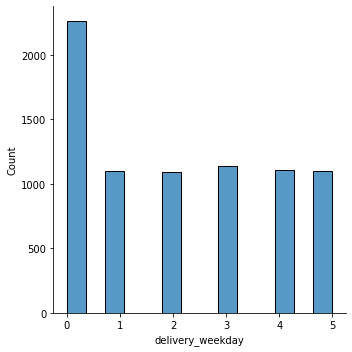

In [25]:
preped = deliveries_v2.copy()
preped["delivery_weekday"]=preped['delivery_timestamp'].apply(lambda x: x.weekday())

plt.figure(figsize=(20,10))
sns.displot(preped["delivery_weekday"])
plt.show()

##### Krótkie dostawy

In [26]:
quick_deliveries = merged_full[merged_full["time[h]"]< 12]
len(quick_deliveries)

65

In [27]:
quick_deliveries["city"].unique()

array([nan, 'Police', 'Mielec', 'Kutno'], dtype=object)

##### Podsumowanie analizy błędów danych

Znalezione błędy zostały poprawione. Widać, że dostawy w poniedziałki występują teraz około dwóch razy częściej
niż te w inne dni tygodnia. Krótkie czasy dostawy (poniżej dwunastu godzin) nadal występują, ale jest to niecały procent danych.
Występują one w 4 różnych miastach w Polsce,
co wraz z informacją o jednym miejscu wysyłki brzmi co najmniej mało prawdopodobnie. Jest tych danych jednak tak mało,
że istnieje możliwość pominięcia ich w dalszym modelowaniu.

### Reprezentatywność

In [28]:
merged_full["city"].unique()

array(['Police', nan, 'Mielec', 'Szczecin', 'Warszawa', 'Radom', 'Kutno',
       'Gdynia', 'Konin'], dtype=object)

In [29]:
users_v2["city"].unique()

array(['Police', 'Mielec', 'Szczecin', 'Warszawa', 'Radom', 'Kutno',
       'Gdynia', 'Konin'], dtype=object)

Wydaje się, że mamy dane dotyczące wszystkich interesujących nas miejsc dostaw, jednak warto byłoby się upewnić,
czy firma faktycznie działa tylko w tych 8 miastach.

In [30]:
cities = merged_full["city"].unique().tolist()
cities_count = [(city, len(merged_full[merged_full["city"]==city])) for city in cities]
cities_count.append(("NaN", len(merged_full[merged_full["city"].isnull()])))
for c, n in cities_count:
  print(f"{c}:{n}")

Police:1181
nan:0
Mielec:761
Szczecin:1118
Warszawa:1045
Radom:1005
Kutno:575
Gdynia:711
Konin:1014
NaN:402


Położenie geograficzne odbiorców jest w miarę równomiernie rozłożone i nie powinno wywoływać problemów.

W danych znajduje się adres danego użytkownika, jednak sam adres (szczególnie w postaci napisu łączącego i ulicę, i numer bloku i numer mieszkania) nie niesie informacji o położeniu geograficznym miejsca dostawy, a także o relacji odległości pomiędzy różnymi adresami dostaw. Prawdopodobnie źle wpłynie to na zdolność modelu do generalizacji, dlatego należałoby zmienić granularność tego atrybutu np. zastępując go odpowiadającym kodem pocztowym, nazwą ulicy bądź nawet samą nazwą miasta. Te opcje będą rozważane w dalszych etapach realizacji projektu.


### Ponowne sprawdzenie właściwości danych


#### Sprawdzenie nowego rozkładu czasu dostawy

<Figure size 1440x720 with 0 Axes>

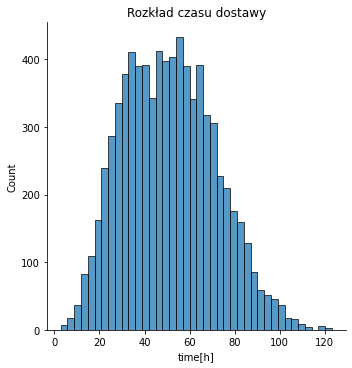

In [31]:
plt.figure(figsize=(20,10))
sns.displot(preped["time[h]"]).set(title="Rozkład czasu dostawy")


Rozkład znacząco się zmienił - maksymalna wartość sięga 120h, zamiast około 220h jak w poprzedniej wersji, środek rozkładu przesunął się dalej od zera. Ogółem rozkład wygląda znacznie bardziej prawdopodobnie i jest zgodny z powszechnym standardem 1-2 dnich roboczych na dostawę. Zniknęło zeń wiele dostaw ultrakrótkich, a zaobserwowane wyjątkowo długie czasy dostaw wynikają najpewniej z rzadkich, lecz prawidłowych zdarzeń. 

#### Sprawdzenie ilości danych

In [32]:
for key, value in data_v2.items():
    print(key, " : ", value.shape)

products  :  (319, 4)
sessions  :  (42883, 7)
users  :  (200, 4)
deliveries  :  (7812, 7)


Danych nadal jest zadowalająco dużo.

#### Sprawdzenie rozkładu dostaw pomiędzy firmami

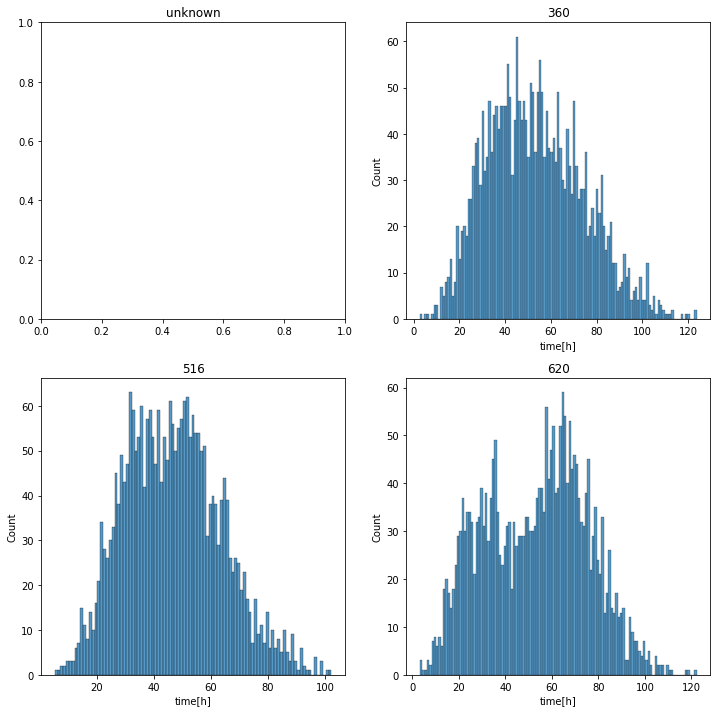

In [33]:
companies = preped["delivery_company"].unique()
dfs = {
    "unknown": preped[preped['delivery_company'].isna()]["time[h]"],
    "360": preped[preped['delivery_company']==360]["time[h]"],
    "516": preped[preped['delivery_company']==516]["time[h]"],
    "620": preped[preped['delivery_company']==620]["time[h]"]
}

fgs, axes = plt.subplots(2, 2, figsize=(12,12))
axs = [axes[i][j] for i in [0,1] for j in [0,1]]
i=0
for key, df in dfs.items():
  sns.histplot(data = df, binwidth=1, ax = axs[i])
  axs[i].title.set_text(key)
  i+=1
plt.show()

Dane o brakujących firmach zostały uzupełnione. Dane w firmach bardziej się różnią - w związku z czym zmienna oznaczająca
firmę dostawczą prawdopodobnie będzie miała większy wpływ w modelowaniu.


### Sprawdzanie powiązań między zmiennymi i wstępny wybór danych wejściowych

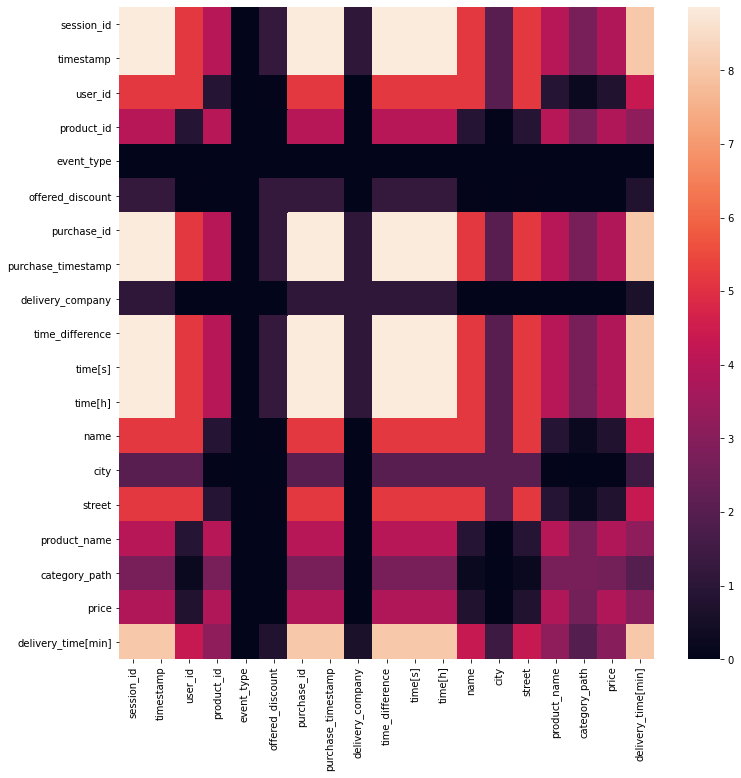

In [34]:
from sklearn.metrics import mutual_info_score

def calc_mutual_info_score(df):
  attributes = df.columns.to_list()
  scores = pd.DataFrame(data = np.zeros((len(attributes), len(attributes))), columns = attributes, index = attributes)
  for i in range(len(attributes)):
    for j in range(i, len(attributes)):
      at1 = attributes[i]
      at2 = attributes[j]
      mi_score = mutual_info_score(df[at1], df[at2])
      scores[at1][at2] = mi_score
      scores[at2][at1] = mi_score
  return scores

#data prep
merged_full["purchase_timestamp"] = pd.to_datetime ( merged_full["purchase_timestamp"], format='%Y-%m-%dT%H:%M', errors="coerce")
merged_full['delivery_timestamp'] = pd.to_datetime ( merged_full["delivery_timestamp"], format='%Y-%m-%dT%H:%M:%S', errors="coerce")
merged_full["delivery_time[min]"] = (merged_full['delivery_timestamp'] - merged_full["purchase_timestamp"]).apply(lambda x: x.total_seconds()//60)
temp = merged_full.drop(labels=["delivery_timestamp"], axis=1)
temp = temp.dropna()

mi_scores = calc_mutual_info_score(temp)
plt.figure(figsize=(12,12))
sns.heatmap(mi_scores)

In [35]:
print("Identical timestamps for purchase and session: ",len(merged_full[merged_full["timestamp"] == merged_full["purchase_timestamp"]]))
print("Different session events: ", merged_full["event_type"].nunique())
print("Different session_ids: ", merged_full["session_id"].nunique())
print("Different purchase_ids: ", merged_full["purchase_id"].nunique())
print("Different buy timestamps: ", merged_full["timestamp"].nunique())

Identical timestamps for purchase and session:  7812
Different session events:  1
Different session_ids:  7812
Different purchase_ids:  7812
Different buy timestamps:  7809


In [36]:
merged_full["purchase_day_of_week"] = merged_full["purchase_timestamp"].apply(lambda x: x.day_name())
merged_full["purchase_hour"] = merged_full["purchase_timestamp"].apply(lambda x: x.hour)


Ze zbioru danych wejściowych możemy na pewno na wstępie odrzucić atrybuty:
- event_type, gdyż jest tylko jeden ("BUY_EVENT"),
- session_id i purchase id, gdyż każdy zakup  ma je unikatowe,
- timestamp, bo jest identyczny do purchase_timestamp, a nie potrzebujemy idealnie zduplikowanych danych,
- purchase timestamp, bo przyjmuje niemal zawsze unikatowe wartości.

Atrybuty "timestamp" i "purchase_timestamp" zastąpione zostaną atrybutami "purchase_day_of_week" (dzień tygodnia) i "purchase_hour" (godzina zakupu zaokrąglona w dół). Spodziewamy się że te zmienne pozwolą lepiej odzwierciedlić spodziewany dobowy i godzinowy trend w rozkładzie czasu dostay.

Ponadto z danych usunięte też będą atrybuty user_id, name i street (która zawiera nie tylko ulicę, ale też numer bloku i mieszkania konkretnego użytkownika), ponieważ nie zawierają informacji, które będą się dobrze generalizować, a raczej te identyfikujące konkretnych użytkowników. Oczywiście adres to prawdopodobnie cenna informacja, przydatna do przewidzenia czasu dostawy, jednak będzie potrzebny na większym poziomie granulacji np. miast, ulic, a może rejonów związanych z kodami pocztowymi.

Atrybuty, które planujemy pozostawić w modelu:
product_id, offered_discount, delivery_company, city,
product_name, category_path, price, purchase_day_of_week, purchase_hour.

Atrybutem wyjściowym modelu będzie: delivery_time[min], obliczany z danych jako różnica czasu pomiędzy delivery_timestamp i purchase_timestamp, zaokrąglona do minut. Z tak wyliczonej różnicy czasowej będzie można później z łatwością wyliczyć przewidywany czas dostawy i zaprezentować klientowi.

In [37]:
selected = merged_full[['product_id', 'offered_discount', 'delivery_company',
                     'city', 'product_name', 'category_path', 'price',
                     'purchase_day_of_week', 'purchase_hour', 'delivery_time[min]']]
target = 'delivery_time[min]'

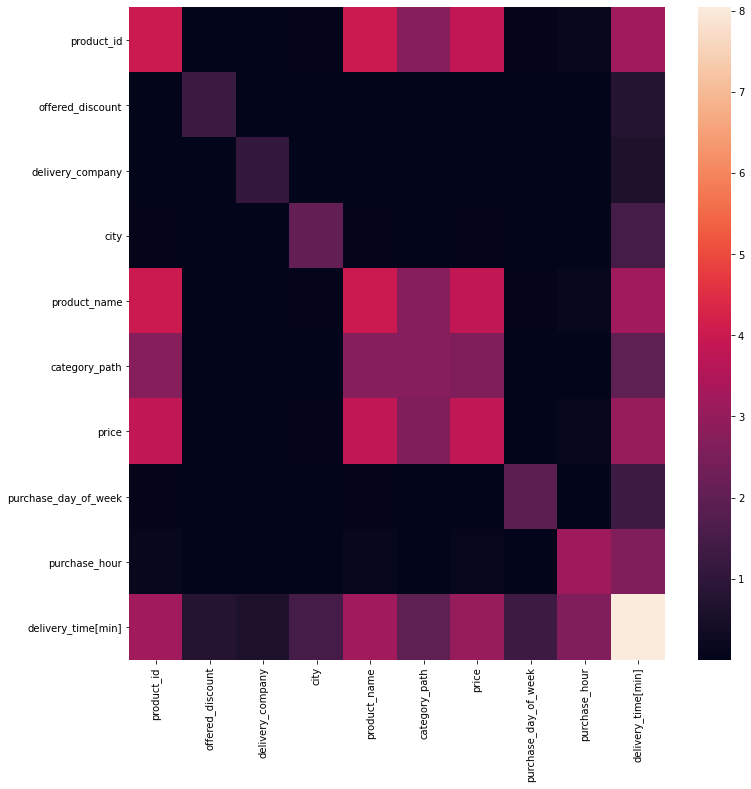

In [38]:
selected = selected.dropna()
mi_scores = calc_mutual_info_score(selected)
plt.figure(figsize=(12,12))
sns.heatmap(mi_scores)

### Drzewo decyzyjne

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error
from sklearn.preprocessing import LabelEncoder


x_train, x_test, y_train, y_test = train_test_split(
    selected.drop(target, axis=1),selected[target], random_state=23, test_size=0.2)

# minimalne przetworzenie danych niezbędne do zastosowania regresji liniowej
categoricals = x_train.select_dtypes(object).columns.to_list()
encoder = LabelEncoder()
for c in categoricals:
  x_train.loc[:,c] = encoder.fit_transform(x_train[c].astype(str))
  x_test.loc[:,c] = encoder.transform(x_test[c].astype(str))



reg = LinearRegression()
reg.fit(x_train, y_train)
pred_train = reg.predict(x_train)
pred_test = reg.predict(x_test)

train_score = median_absolute_error(pred_train, y_train)
test_score = median_absolute_error(pred_test, y_test)
print(f'Train Median absolute error: {train_score}, test Median absolute error: {test_score}')

Train Median absolute error: 780.3592599998249, test Median absolute error: 803.5931909265801


### Wnioski i pytania

Dane uległy znaczącej poprawie, wyeliminowano większość znalezionych błędów. Otrzymane dane wydają się dostatecznie dobre do zbudowania modelu o satysfakcjonującym działaniu, co potwierdziliśmy sprawdzając wyniki działania algorytmu regresji liniowej z minimalnym wstępnym przetworzeniem danych. 
Nadal mamy problem z bardzo krótkimi czasami dostawy, ale jest to na tyle mało przypadków,
że będzie można rozważyć ich pominięcie przy procesie uczenia.

Na podstawie kolejnej analizy pojawiły się nowe pytania:
- Czy jest możliwość uzupełnienia brakujących informacji o użytkownikach, którzy zakupili produkty? (Braki w kolumnie *user_id* w tabeli *sessions*).
- Czy firma działa tylko w 8 miastach obecnych w danych?

